# Block Space Market
Author: [@typerbole](https://twitter.com/typerbole), [GitHub](https://github.com/ty-perbole), [stack-stats.com](http://www.stack-stats.com)

This is the fourth notebook in the [Stack Stats](http://www.stack-stats.com) repository. See the [Stack Stats readme](https://github.com/ty-perbole/stack-stats/blob/master/README.md) for more about this project and further instructions in how to run the jupyter notebook. This tutorial assumes a basic familiarity with Python and SQL.

In this tutorial we are going to pull some data on the fees paid on Bitcoin transactions to be included Bitcoin blocks. Block space is a scarce resource. From Wikipedia: "The on-chain transaction processing capacity of the bitcoin network is limited by the average block creation time of 10 minutes and the block size limit of 1 megabyte." Because block space is scarce, users typically pay fees to get their transactions included in Bitcoin blocks. Fees are typically denominated in Sats/vByte, and it is this price which helps provision usage of the scarce resource of Bitcoin block space.

The organic emergence of a block space market is a necessary condition for Bitcoin's security model to scale past the era of large block subsidies, which are decreasing by 50% every four years (AKA the halving). So it's important to track how this market is evolving.

In the first part of this notebook we'll plot some heatmap plots to show how block space price distribution changes over time. In the second part we'll try to fit a model to predict block space price as a function of transaction volume demand.

# Types of fees

Block space is usually priced as:

## ${Block\ Space\ Price}=\frac{Total\ Fee\ Paid}{Transaction\ Size}$

For the numerator we can measure the fee paid in either BTC or USD. Both are useful and tell a bit different story.

For the denominator the transaction size is measured in vBytes, which is the size of the transaction with some adjustments made for SegWit. See this [Stack Exchange post](https://bitcoin.stackexchange.com/questions/89385/is-there-a-difference-between-bytes-and-virtual-bytes-vbytes) for an explainer of vBytes.

# Query for the data

To obtain our fee data we are going to run a simple query against the the Bitcoin Transactions SQL table on Google BigQuery. I cover how to do this in more detail in tutorial #2, [02_HODLWavesPart1](https://ty-perbole.github.io/stack-stats/02_HODLWavesPart1.html), so I will not repeat the basics and move right along to the query. You will also need to import a private table into your BigQuery with price data from CoinMetrics as described in tutorial #3, [03_HODLWavesPart2RealizedCap](https://ty-perbole.github.io/stack-stats/03_HODLWavesPart2RealizedCap.html).

**You should be very careful when using BigQuery against the Bitcoin data as it is easy to run many queries, exceed your free usage and incur cloud fees. I am not responsible for your query usage.**

Below is the simple query we will run to get our data. It should be pretty self-explanatory. As usual I will provide the output CSV so you don't have to run the query yourself.

I created fee buckets for transactions in Sats and USD roughly based on 5% percentiles.

In [1]:
QUERY = '''
-- This is the coinmetrics BTC community data imported into BigQuery, as described in tutorial #3
WITH cm AS (
SELECT
  date,
  PriceUSD
FROM
-- ** YOU WILL HAVE TO REPLACE THE PROJECT NAME HERE TO REFLECT YOUR OWN BIGQUERY TABLE **
  `replace_this_project.bitcoin.cm_btc`),
  
fees AS
(SELECT
  -- Transaction date
  DATE(tx.block_timestamp) AS date,
  
  -- Fee in sats/vByte. Rounded to nearest integer and capped at 1k to reduce row size
  IF(ROUND(tx.fee / tx.virtual_size, 0) > 1000, 1000, ROUND(tx.fee / tx.virtual_size, 0)) AS sats_per_vbyte,
  -- Fee bucket in sats/vByte
  CASE
    WHEN tx.fee / tx.virtual_size = 0 THEN '0'
    WHEN tx.fee / tx.virtual_size < 2 THEN '0-2'
    WHEN tx.fee / tx.virtual_size < 4 THEN '2-4'
    WHEN tx.fee / tx.virtual_size < 6 THEN '4-6'
    WHEN tx.fee / tx.virtual_size < 9 THEN '6-9'
    WHEN tx.fee / tx.virtual_size < 12 THEN '9-12'
    WHEN tx.fee / tx.virtual_size < 18 THEN '12-18'
    WHEN tx.fee / tx.virtual_size < 24 THEN '18-24'
    WHEN tx.fee / tx.virtual_size < 30 THEN '24-30'
    WHEN tx.fee / tx.virtual_size < 40 THEN '30-40'
    WHEN tx.fee / tx.virtual_size < 50 THEN '40-50'
    WHEN tx.fee / tx.virtual_size < 60 THEN '50-60'
    WHEN tx.fee / tx.virtual_size < 80 THEN '60-80'
    WHEN tx.fee / tx.virtual_size < 100 THEN '80-100'
    WHEN tx.fee / tx.virtual_size < 130 THEN '100-130'
    WHEN tx.fee / tx.virtual_size < 170 THEN '130-170'
    WHEN tx.fee / tx.virtual_size < 220 THEN '170-220'
    WHEN tx.fee / tx.virtual_size < 350 THEN '220-350'
    WHEN tx.fee / tx.virtual_size < 600 THEN '350-600'
    WHEN tx.fee / tx.virtual_size >= 600 THEN '600+'
    ELSE 'NA' END AS sats_per_vbyte_bucket,
    
  -- Fee in USD/vbye. Rounded to nearest tenth of a dollar and capped at $100 to reduce row size
  IF(ROUND((tx.fee * cm.PriceUSD / 100000000) / tx.virtual_size, 6) > 100, 100, ROUND((tx.fee * cm.PriceUSD / 100000000) / tx.virtual_size, 6)) AS usd_per_vbyte,
  -- Fee bucket in USD/vByte
  CASE
    WHEN (tx.fee * cm.PriceUSD / 100000000) / tx.virtual_size = 0 THEN '$0'
    WHEN (tx.fee * cm.PriceUSD / 100000000) / tx.virtual_size < 0.00005 THEN '$0-$0.00005'
    WHEN (tx.fee * cm.PriceUSD / 100000000) / tx.virtual_size < 0.00008 THEN '$0.00005-$0.00008'
    WHEN (tx.fee * cm.PriceUSD / 100000000) / tx.virtual_size < 0.0001 THEN '$0.00008-$0.0001'
    WHEN (tx.fee * cm.PriceUSD / 100000000) / tx.virtual_size < 0.00015 THEN '$0.0001-$0.00015'
    WHEN (tx.fee * cm.PriceUSD / 100000000) / tx.virtual_size < 0.0002 THEN '$0.00015-$0.0002'
    WHEN (tx.fee * cm.PriceUSD / 100000000) / tx.virtual_size < 0.00025 THEN '$0.0002-$0.00025'
    WHEN (tx.fee * cm.PriceUSD / 100000000) / tx.virtual_size < 0.0003 THEN '$0.00025-$0.0003'
    WHEN (tx.fee * cm.PriceUSD / 100000000) / tx.virtual_size < 0.0004 THEN '$0.0003-$0.0004'
    WHEN (tx.fee * cm.PriceUSD / 100000000) / tx.virtual_size < 0.0005 THEN '$0.0004-$0.0005'
    WHEN (tx.fee * cm.PriceUSD / 100000000) / tx.virtual_size < 0.00065 THEN '$0.0005-$0.00065'
    WHEN (tx.fee * cm.PriceUSD / 100000000) / tx.virtual_size < 0.0009 THEN '$0.00065-$0.0009'
    WHEN (tx.fee * cm.PriceUSD / 100000000) / tx.virtual_size < 0.001 THEN '$0.0009-$0.001'
    WHEN (tx.fee * cm.PriceUSD / 100000000) / tx.virtual_size < 0.0015 THEN '$0.001-$0.0015'
    WHEN (tx.fee * cm.PriceUSD / 100000000) / tx.virtual_size < 0.002 THEN '$0.0015-$0.002'
    WHEN (tx.fee * cm.PriceUSD / 100000000) / tx.virtual_size < 0.003 THEN '$0.002-$0.003'
    WHEN (tx.fee * cm.PriceUSD / 100000000) / tx.virtual_size < 0.0045 THEN '$0.003-$0.0045'
    WHEN (tx.fee * cm.PriceUSD / 100000000) / tx.virtual_size < 0.007 THEN '$0.0045-$0.007'
    WHEN (tx.fee * cm.PriceUSD / 100000000) / tx.virtual_size < 0.01 THEN '$0.007-$0.01'
    WHEN (tx.fee * cm.PriceUSD / 100000000) / tx.virtual_size < 0.15 THEN '$0.01-$0.15'
    WHEN (tx.fee * cm.PriceUSD / 100000000) / tx.virtual_size >= 0.15 THEN '$0.15+'
    ELSE 'NA' END AS usd_per_vbyte_bucket,
  tx.fee AS fee,
  tx.fee * cm.PriceUSD / 100000000 AS fee_usd,
  tx.virtual_size AS virtual_size
FROM
  `bigquery-public-data.crypto_bitcoin.transactions` AS tx
JOIN
  cm
ON
  DATE(tx.block_timestamp) = cm.date
WHERE
  NOT(tx.is_coinbase))

-- Run and save this query for the data in part 1
SELECT
  month,
  bucket,
  bucket_type,
  tx_count
FROM

    (SELECT
      -- Aggregate per month to make data more manageable
      DATE_TRUNC(date, MONTH) AS month,
      sats_per_vbyte_bucket AS bucket,
      'sats' AS bucket_type,
      SUM(1) AS tx_count
    FROM
      fees
    GROUP BY
      month,
      bucket,
      bucket_type)
  
UNION ALL

    (SELECT
      -- Aggregate per month to make data more manageable
      DATE_TRUNC(date, MONTH) AS month,
      usd_per_vbyte_bucket AS bucket,
      'usd' AS bucket_type,
      SUM(1) AS tx_count
    FROM
      fees
    GROUP BY
      month,
      bucket,
      bucket_type)
  
ORDER BY
  month ASC, bucket_type, bucket
;
  
-- Run and save this query for the data in part 2
-- SELECT
--   date,
--   SUM(fee) AS sum_fees_sats,
--   SUM(fee_usd) AS sum_fees_usd,
--   SUM(virtual_size) AS sum_block_vbytes
-- FROM
--   fees
-- GROUP BY
--   date
-- ORDER BY
--   date ASC;
'''
print(QUERY)


-- This is the coinmetrics BTC community data imported into BigQuery, as described in tutorial #3
WITH cm AS (
SELECT
  date,
  PriceUSD
FROM
-- ** YOU WILL HAVE TO REPLACE THE PROJECT NAME HERE TO REFLECT YOUR OWN BIGQUERY TABLE **
  `replace_this_project.bitcoin.cm_btc`),
  
fees AS
(SELECT
  -- Transaction date
  DATE(tx.block_timestamp) AS date,
  
  -- Fee in sats/vByte. Rounded to nearest integer and capped at 1k to reduce row size
  IF(ROUND(tx.fee / tx.virtual_size, 0) > 1000, 1000, ROUND(tx.fee / tx.virtual_size, 0)) AS sats_per_vbyte,
  -- Fee bucket in sats/vByte
  CASE
    WHEN tx.fee / tx.virtual_size = 0 THEN '0'
    WHEN tx.fee / tx.virtual_size < 2 THEN '0-2'
    WHEN tx.fee / tx.virtual_size < 4 THEN '2-4'
    WHEN tx.fee / tx.virtual_size < 6 THEN '4-6'
    WHEN tx.fee / tx.virtual_size < 9 THEN '6-9'
    WHEN tx.fee / tx.virtual_size < 12 THEN '9-12'
    WHEN tx.fee / tx.virtual_size < 18 THEN '12-18'
    WHEN tx.fee / tx.virtual_size < 24 THEN '18-24'
    WHEN tx.f

# Part 1: Block Space Price Histograms

In [1]:
import os
import pandas as pd
import numpy as np
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation_mpl

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import chart_utils
import analysis_utils

Now that we have our data from BigQuery we can import it into our Jupyter notebook and create the plots.

In [2]:
# # Download CoinMetrics data if needed

# try:
#     os.remove("btc.csv")
# except FileNotFoundError:
#     pass
# !wget https://coinmetrics.io/newdata/btc.csv

--2020-10-29 20:18:09--  https://coinmetrics.io/newdata/btc.csv
Resolving coinmetrics.io (coinmetrics.io)... 104.26.14.66, 172.67.75.174, 104.26.15.66
Connecting to coinmetrics.io (coinmetrics.io)|104.26.14.66|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2713137 (2.6M) [application/octet-stream]
Saving to: ‘btc.csv’

btc.csv             100%[===================>]   2.59M  --.-KB/s    in 0.1s    

2020-10-29 20:18:09 (23.9 MB/s) - ‘btc.csv’ saved [2713137/2713137]



In [14]:
fee_data.bucket.unique()

array(['0', nan, '600+', '$0', '$0-$0.00005', '0-2', '130-170', '100-130',
       '170-220', '220-350', '24-30', '30-40', '350-600', '40-50',
       '60-80', '18-24', '50-60', '6-9', '$0.00005-$0.00008',
       '$0.00008-$0.0001', '$0.0001-$0.00015', '$0.0002-$0.00025', '2-4',
       '4-6', '$0.00015-$0.0002', '$0.00025-$0.0003', '$0.0003-$0.0004',
       '$0.0004-$0.0005', '12-18', '80-100', '$0.001-$0.0015',
       '$0.0015-$0.002', '$0.002-$0.003', '$0.003-$0.0045', '9-12',
       '$0.0005-$0.00065', '$0.00065-$0.0009', '$0.0009-$0.001',
       '$0.0045-$0.007', '$0.007-$0.01', '$0.01-$0.15', '$0.15+'],
      dtype=object)

In [8]:
# Read in the transaction fee data
fee_data = pd.read_csv("data/04_block_space_price_heat.csv")

# Add in some useful date columns for aggregation
fee_data = analysis_utils.get_extra_datetime_cols(fee_data, 'month')

# Get list of unique months
months = fee_data['month_string'].unique()

# Aggregate data by Sats fee bucket
fee_data_sats = fee_data.loc[fee_data['bucket_type'] == 'sats'].reset_index(drop=True). \
    groupby(['month_string', 'bucket'], group_keys=False).sum()[['tx_count']]

# Aggregate data by USD fee bucket
fee_data_usd = fee_data.loc[fee_data['bucket_type'] == 'usd'].reset_index(drop=True). \
    groupby(['month_string', 'bucket'], group_keys=False).sum()[['tx_count']]

In [9]:
# Read in price and transaction volume data from CoinMetrics
price_data = pd.read_csv(
    "btc.csv"
)
# Add in some useful date columns for aggregation
price_data = analysis_utils.get_extra_datetime_cols(price_data, 'date')

# Calculate some rolling averages of transaction volume and transaction count
price_data['transaction_volume_usd'] = price_data['TxTfrValUSD'].rolling(28).mean()
price_data['transaction_volume_btc'] = price_data['TxTfrValNtv'].rolling(28).mean()
price_data['transaction_count'] = price_data['TxCnt'].rolling(28).mean()

# Calculate monthly averages for the price and transaction volume data
price_data_monthly = price_data.groupby(['month_string'], group_keys=False).mean()[
    ['PriceUSD', 'transaction_volume_btc', 'transaction_volume_usd', 'transaction_count']]

I put together a function in chart_utils.py, block_space_price_heatmap() that will plot our heatmap charts. See chart_utils.py if you're interested in the plotting.

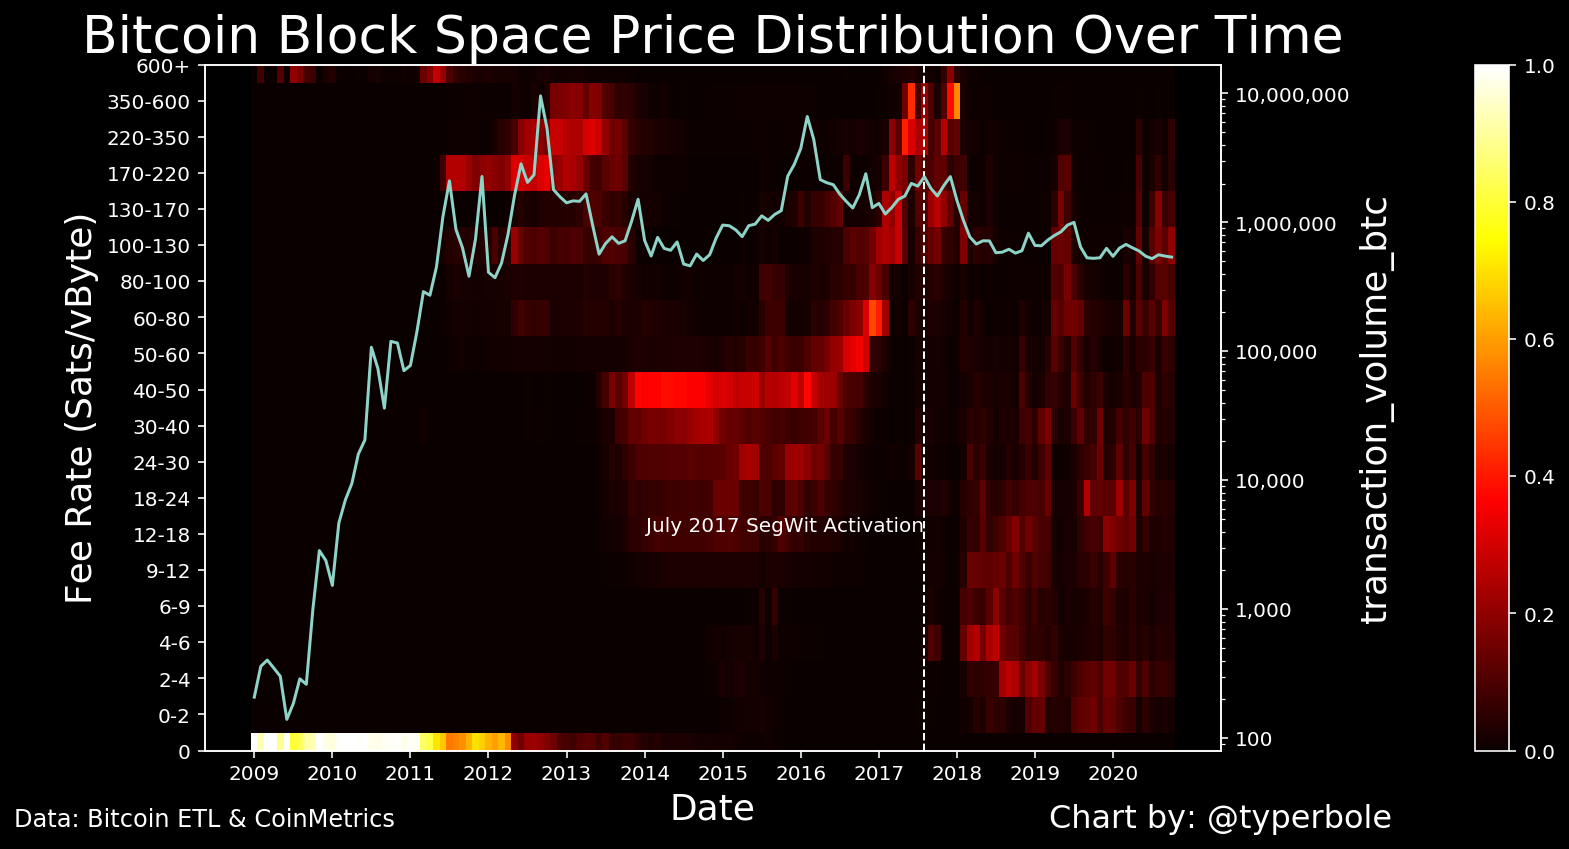

In [10]:
chart_utils.block_space_price_heatmap(
    fee_data_sats, months, price_data_monthly, type='sats', data_source='Bitcoin ETL & CoinMetrics')

You can spot definite trends in the distribution of blockspace price denominated in Sats over time. I see four eras of fee distribution:
- 2009-11: free lunch
- 2011-13: higher fees, 170-350 Sats/vByte
- 2013-16: lower fees, large streak at 40-50 Sats/vByte
- 2017+: fees more responsive to demand

Let's take a look at the same chart with fees denominated in USD.

/Users/tylerwood/git/stack-stats/chart_utils.py:551: RuntimeWarning:

invalid value encountered in true_divide



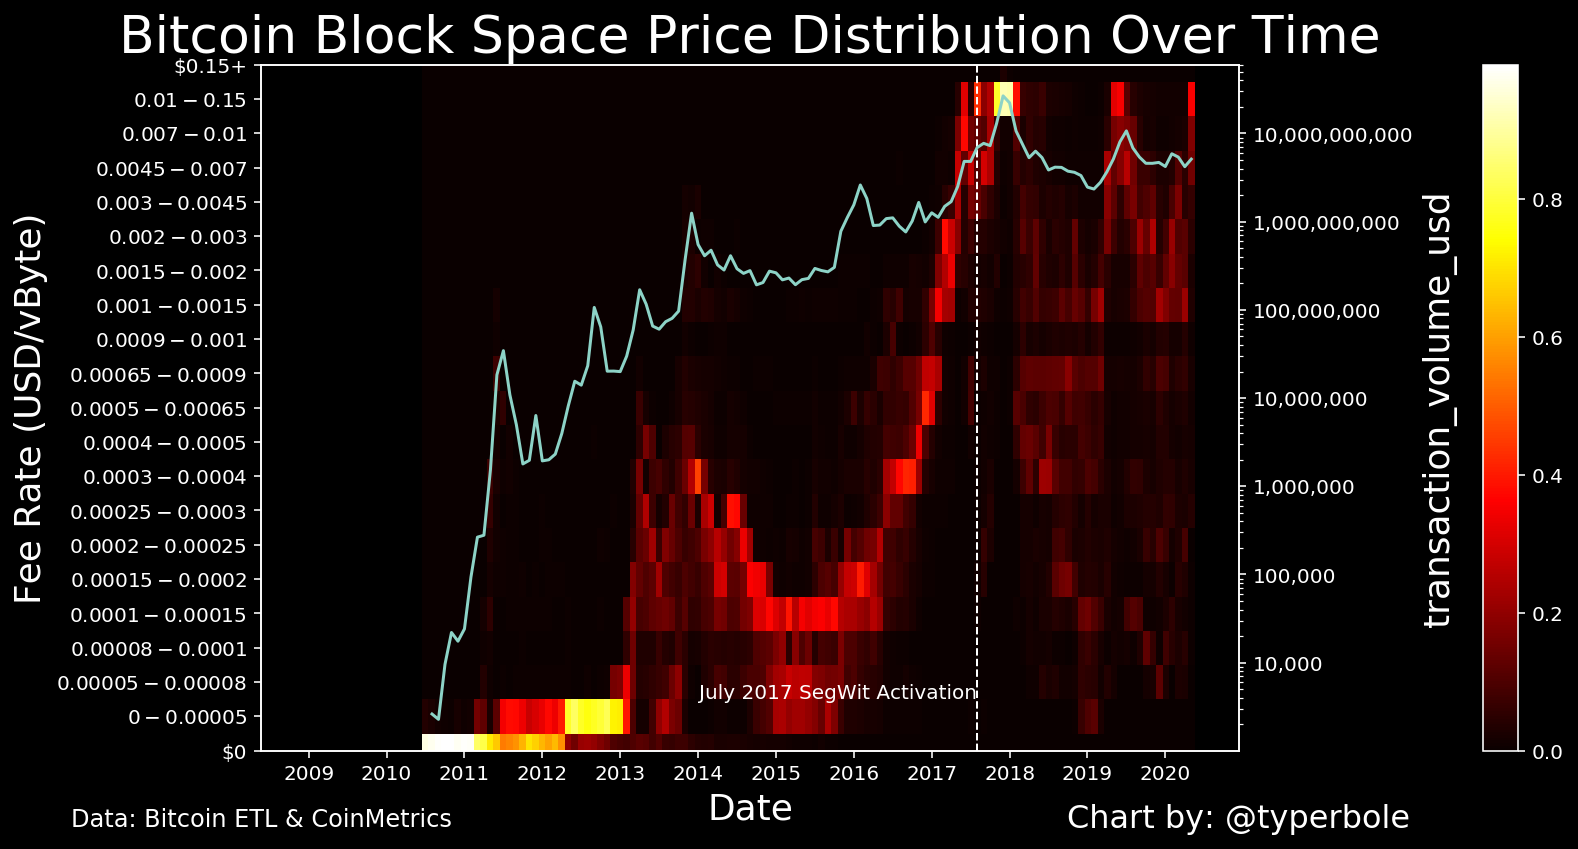

In [7]:
test = chart_utils.block_space_price_heatmap(
    fee_data_usd, months, price_data_monthly, type='usd', data_source='Bitcoin ETL & CoinMetrics')

This chart, with fees and volume denominated in USD, looks more responsive. This makes sense because USD is still likely the chief unit of account for most Bitcoin businesses and users.

Let's try to quantify this relationship in the next section.

# Part 2: Block space model

In [15]:
import statsmodels.api as sm

/Users/tylerwood/anaconda3/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [28]:
block_space_daily = pd.read_csv("data/04_block_space_daily.csv")

# Join the price data onto the blockspace dataframe
block_space_daily = block_space_daily.merge(price_data[
    ['date', 'PriceUSD', 'datetime', 'month_string', 'week_string', 'year_string', 
     'TxTfrValUSD', 'TxTfrValNtv']], on='date')

# Calculate daily mean fee rate
block_space_daily['fees_sats_per_vbyte'] = block_space_daily['sum_fees_sats'] / block_space_daily['sum_block_vbytes']
block_space_daily['fees_usd_per_vbyte'] = block_space_daily['sum_fees_usd'] / block_space_daily['sum_block_vbytes']

# Let's only look at data > 2018, as this is when SegWit usage hits critical mass
block_space_daily_recent = block_space_daily.loc[(block_space_daily['date'] >= '2018-01-01') & (block_space_daily['date'] < '2020-10-29')]

Let's plot the relationship between daily USD transaction volume and daily mean fee rate (USD / vByte).

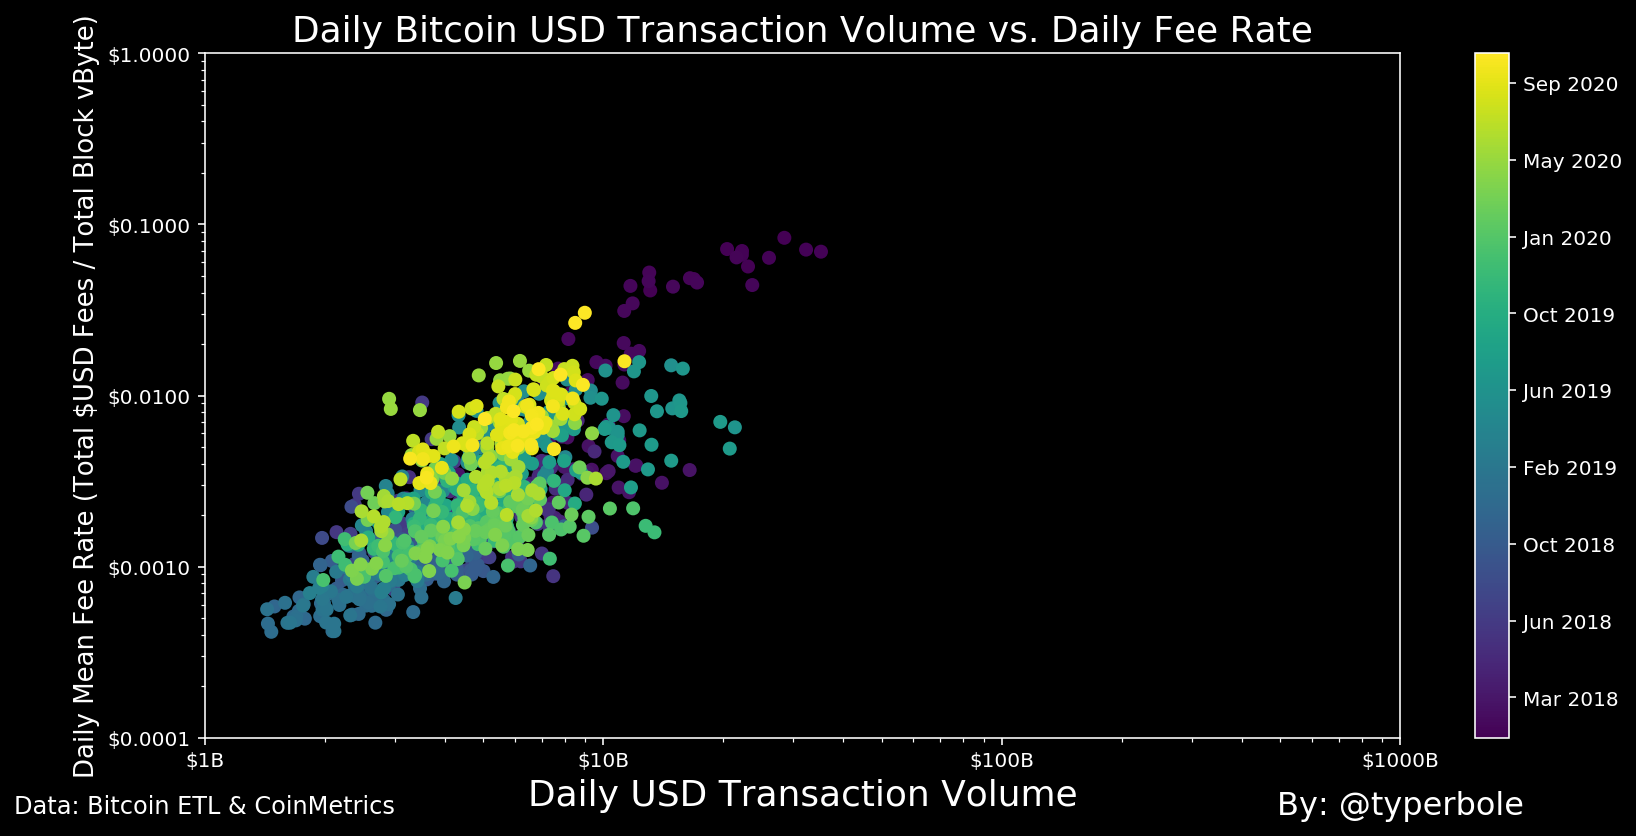

In [29]:
fig = plt.figure(
        figsize=[12, 6],
        clear=True,
        tight_layout=True
)

ax = plt.scatter(
    block_space_daily_recent['TxTfrValUSD'], block_space_daily_recent['fees_usd_per_vbyte'],
    c=block_space_daily_recent['datetime']).axes

ax.set_yscale("log")
ax.set_ylim(0.0001, 1)
ax.set_yticklabels(['${:.4f}'.format(x) for x in ax.get_yticks()])
ax.set_ylabel('Daily Mean Fee Rate (Total $USD Fees / Total Block vByte)', fontsize=13)

ax.set_xscale("log")
ax.set_xlim(1000000000, 1000000000000)
ax.set_xticklabels(['${:.0f}B'.format(x / 1000000000) for x in ax.get_xticks()])
ax.set_xlabel('Daily USD Transaction Volume', fontsize=18)

ax.set_title('Daily Bitcoin USD Transaction Volume vs. Daily Fee Rate', fontsize=18)

ax.text(
    1, -0.1,
    "By: @typerbole",
    transform=ax.transAxes,
    horizontalalignment='center',
    verticalalignment='center', fontsize=16
)

ax.text(
    0, -0.1,
    "Data: Bitcoin ETL & CoinMetrics",
    transform=ax.transAxes,
    horizontalalignment='center',
    verticalalignment='center', fontsize=12
)

cbar = plt.colorbar()
cbar.ax.set_yticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%b %Y'))
plt.show()

That looks like a pretty nice linear relationship when viewed on a log-log scale. As you can see by the different colors points around the same time tend to cluster together. The early 2018 points (purple) may be outliers.


Let's build a simple model to capture this relationship.

In [30]:
# Create our data series
X = np.log(block_space_daily_recent['TxTfrValUSD'])
X = sm.add_constant(X)
y = np.log(block_space_daily_recent['fees_usd_per_vbyte'])

# Fit our model
model = sm.OLS(y, X).fit()

# Let's make predictions for the model over a range of transaction volume values so we can plot the line
line_x = np.log(np.arange(1000000000, 1000000000000, 1000000000))
line_x = sm.add_constant(line_x)
line_y = model.get_prediction(line_x, transform=False)

# We'll also get the prediction & confidence intervals
prediction_interval = line_y.summary_frame(alpha=0.05)
line_y_mean = np.exp(prediction_interval['mean'])
line_y_lower_ci = np.exp(prediction_interval['obs_ci_lower'])
line_y_upper_ci = np.exp(prediction_interval['obs_ci_upper'])
line_y_lower_pi = np.exp(prediction_interval['mean_ci_lower'])
line_y_upper_pi = np.exp(prediction_interval['mean_ci_upper'])

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     fees_usd_per_vbyte   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     1385.
Date:                Thu, 29 Oct 2020   Prob (F-statistic):          8.03e-193
Time:                        20:28:09   Log-Likelihood:                -937.71
No. Observations:                1032   AIC:                             1879.
Df Residuals:                    1030   BIC:                             1889.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -38.0890      0.863    -44.137      0.000     -39.782     -36.396
TxTfrValUSD     1.4403      0.039     37.218      0.000       1.364       1.516
==============================================================================
Omnibus:                       12.625   Durbin-Watson:                   0.468
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               12.856
Skew:                           0.273   Prob(JB):                      0.00162
Kurtosis:                       3.015   Cond. No.                     1.03e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.03e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Let's look at the fit and the residuals.

/Users/tylerwood/anaconda3/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/tylerwood/anaconda3/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/tylerwood/anaconda3/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



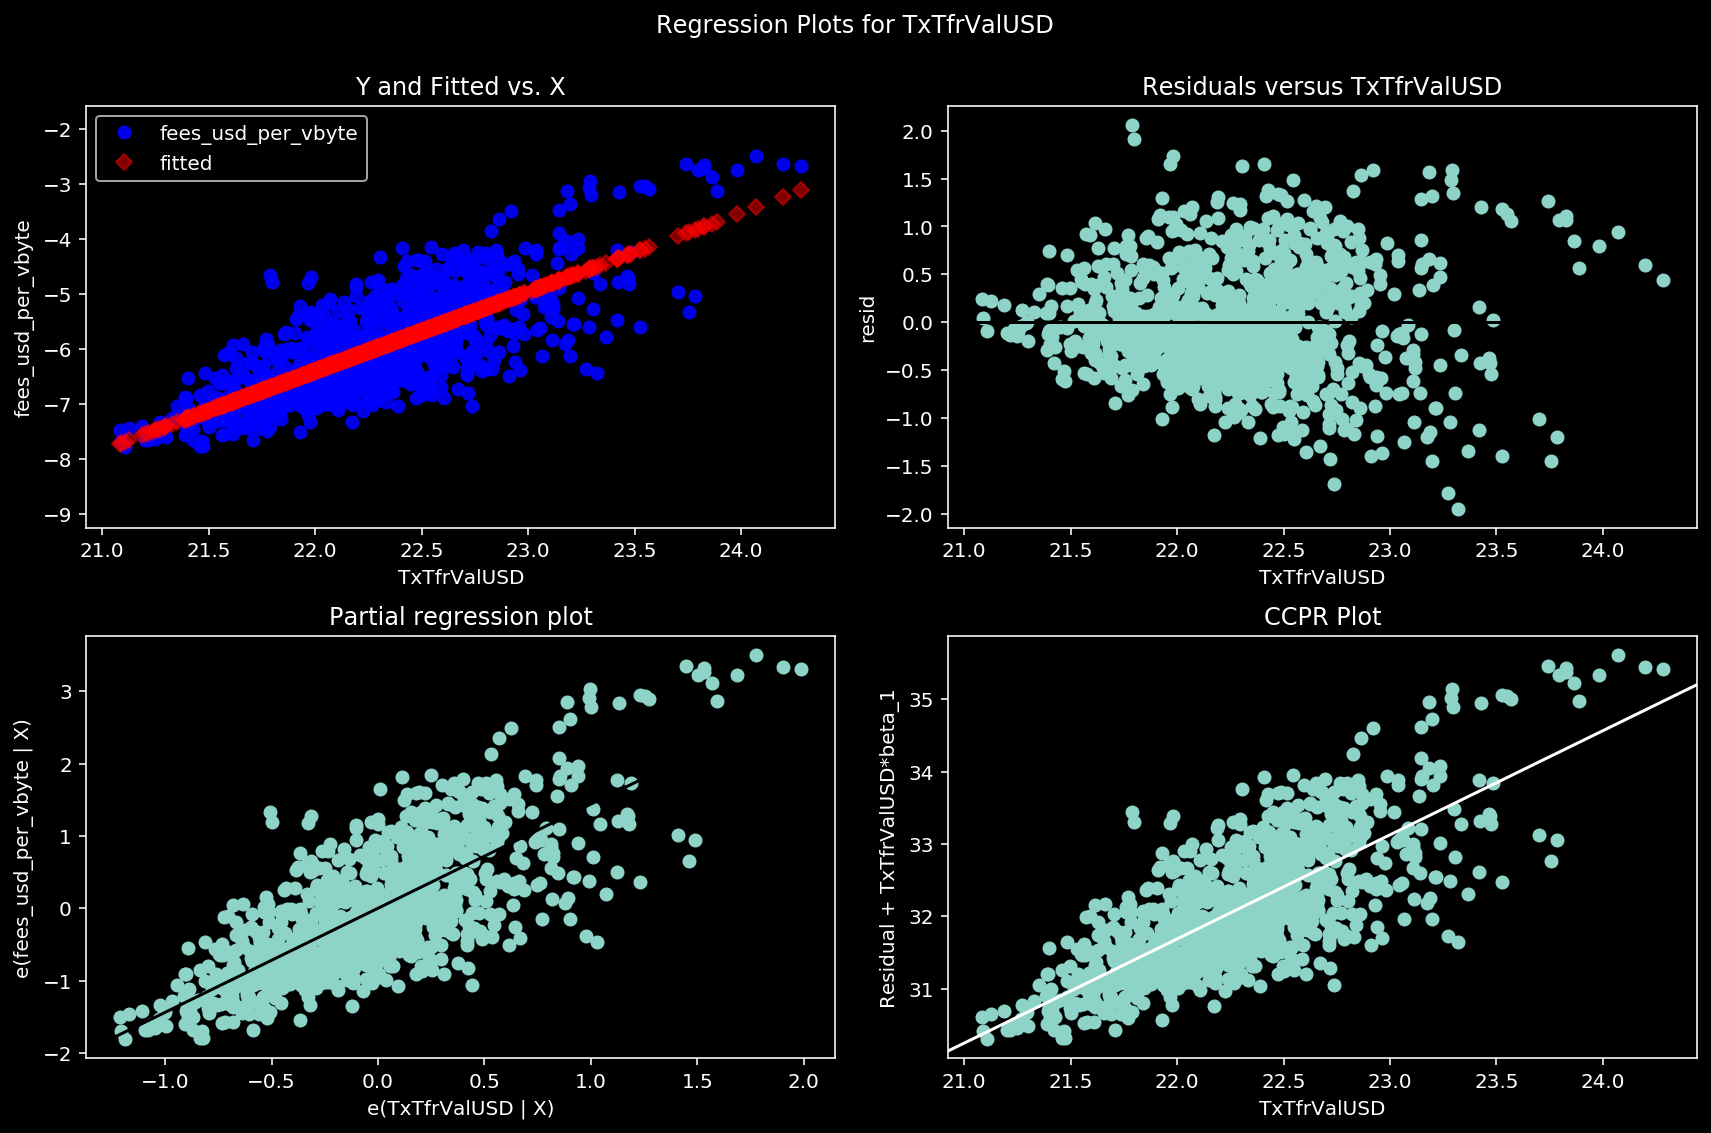

In [31]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model, 'TxTfrValUSD', fig=fig)

The residual plot (upper right) should be randomly distributed for the assumptions underlying the regression to be valid. See [here](https://stattrek.com/regression/residual-analysis.aspx) for a brief explanation.

You might notice that there are "missing points" from the lower left of the residual plot, and that the residuals get a little more extreme with higher values of transaction volume. This is a valid critique, but I'm not too worried about the residual pattern. 

Unfortunately we don't have data for a full market cycle with SegWit activated and widely used, so it makes sense to me that we might not have a complete residual plot. The "missing" area would represent low volume, low fee era that would have existed before SegWit but was not included in the dataset.

Real world data rarely matches the platonic ideals taught in statistics textbooks. It's up to you to weight the results of a model against the real-world justification (does it make sense that fees increase when transaction volume increases?) and potential statistical caveats (potential heteroskedasticity and other problems) and arrive at your own confidence in the findings.

Let's plot the final model over the original scatterplot!

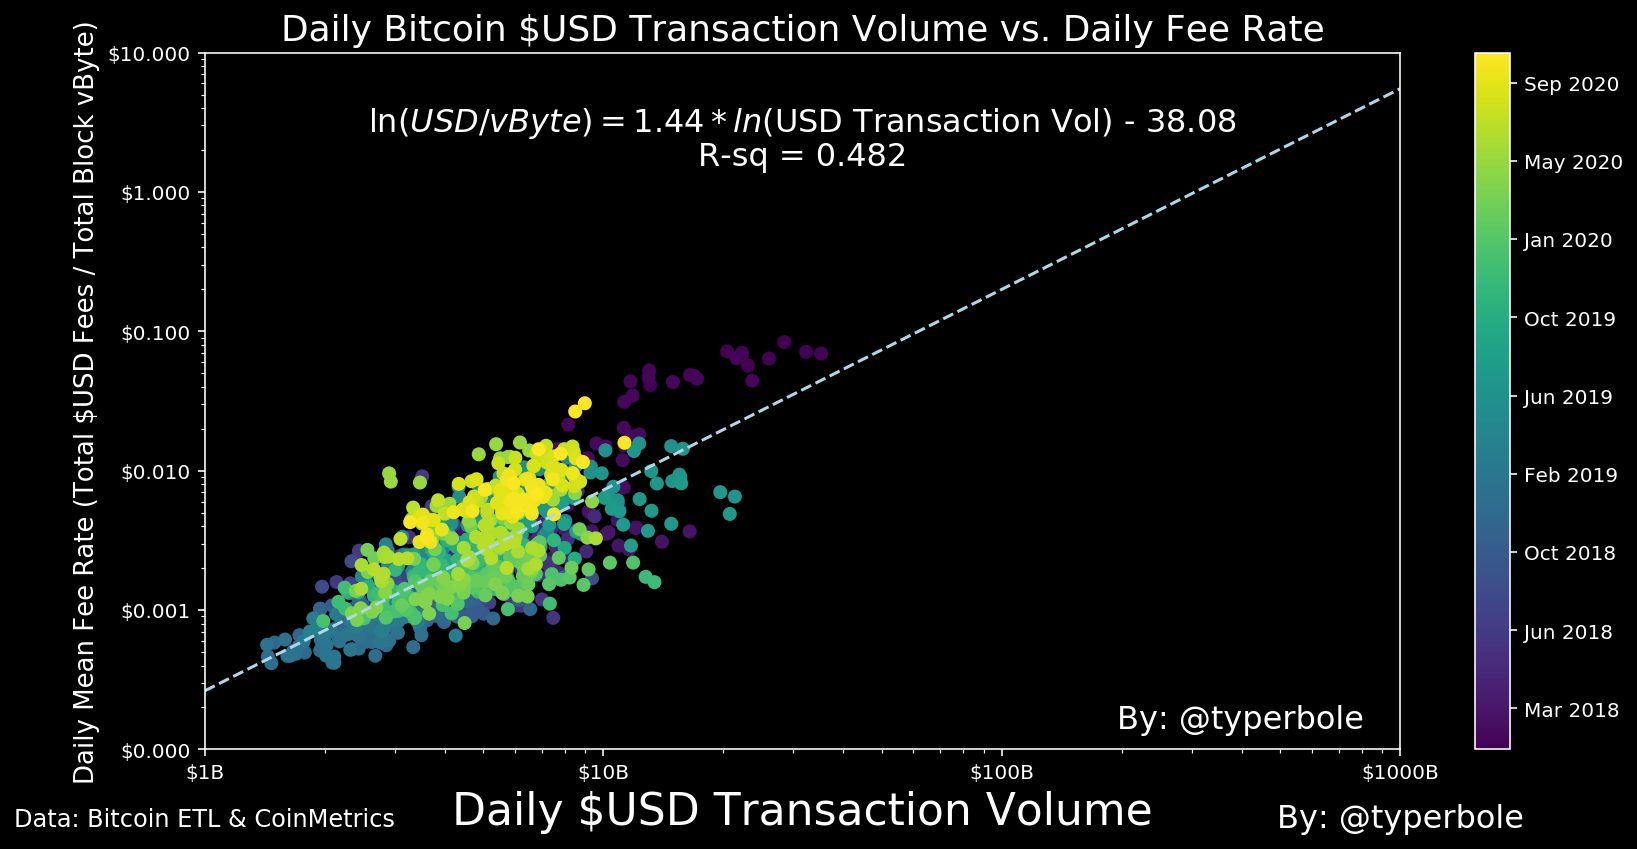

In [34]:
fig = plt.figure(
        figsize=[12, 6],
        clear=True,
        tight_layout=True
)

ax = plt.scatter(
    block_space_daily_recent['TxTfrValUSD'], block_space_daily_recent['fees_usd_per_vbyte'],
    c=block_space_daily_recent['datetime'], 
#     cmap='hot'
).axes

ax.set_yscale("log")
ax.set_ylim(0.0001, 10)
ax.set_yticklabels(['${:.3f}'.format(x) for x in ax.get_yticks()])
ax.set_ylabel('Daily Mean Fee Rate (Total $USD Fees / Total Block vByte)', fontsize=13)

ax.set_xscale("log")
ax.set_xlim(1000000000, 1000000000000)
ax.set_xticklabels(['${:.0f}B'.format(x / 1000000000) for x in ax.get_xticks()])
ax.set_xlabel('Daily $USD Transaction Volume', fontsize=22)

ax.set_title('Daily Bitcoin $USD Transaction Volume vs. Daily Fee Rate', fontsize=18)
ax.text(
        0.97, 0.02,
        "By: @typerbole",
        transform=ax.transAxes,
        horizontalalignment='right',
        verticalalignment='bottom', fontsize=16
)
ax.text(0.5, 0.9, 
        "ln($USD/vByte) = 1.44 * ln($USD Transaction Vol) - 38.08",
         transform = ax.transAxes,
         horizontalalignment='center',
         verticalalignment='center', fontsize=16
        )
ax.text(0.5, 0.85, 
        "R-sq = 0.482",
         transform = ax.transAxes,
         horizontalalignment='center',
         verticalalignment='center', fontsize=16
       )

ax.plot(
    np.arange(1000000000, 1000000000000, 1000000000), line_y_mean, linestyle='dashed', color='lightblue',
    label='Model Prediction')
# ax.plot(
#     np.arange(1000000000, 1000000000000, 1000000000), line_y_lower_ci, linestyle='dashed', color='lightblue',
#     label='95% Confidence Interval')
# ax.plot(
#     np.arange(1000000000, 1000000000000, 1000000000), line_y_upper_ci, linestyle='dashed', color='lightblue')
# ax.plot(
#     np.arange(1000000000, 1000000000000, 1000000000), line_y_lower_pi, linestyle='dotted', color='lightblue',
#     label='95% Prediction Interval')
# ax.plot(
#     np.arange(1000000000, 1000000000000, 1000000000), line_y_upper_pi, linestyle='dotted', color='lightblue')
# ax.legend(loc="right")

ax.text(
    1, -0.1,
    "By: @typerbole",
    transform=ax.transAxes,
    horizontalalignment='center',
    verticalalignment='center', fontsize=16
)

ax.text(
    0, -0.1,
    "Data: Bitcoin ETL & CoinMetrics",
    transform=ax.transAxes,
    horizontalalignment='center',
    verticalalignment='center', fontsize=12
)

cbar = plt.colorbar()
cbar.ax.set_yticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%b %Y'))
plt.savefig('img/04_block_space_regression.png'.format(type))
plt.show()